# Tasks

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
debt = pd.read_csv('debt.csv')

# 1

Preprocess the public debt file to obtain a data frame with country, type of debt, date and amount of debt.

In [84]:
debt_long = debt.melt(id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'], var_name='Date', value_name='Debt')
debt_long.dropna(subset = 'Debt', inplace=True)
debt_long = debt_long[debt_long['Debt'] != 0]
debt_long.loc[:, 'Date'] = debt_long['Date'].str.split(' ').str[0]
debt_long.reset_index(drop=True, inplace=True)

# TODO should we round the debt values?

# 2

Create a function that receives a country and a date and returns a dictionary with the total internal, external, local currency, foreign currency, short term and long term debt of that country on that date.

In [85]:
def extract_data(country, date):
    df = debt_long[(debt_long['Country Name'] == country) & (debt_long['Date'] == date)]
    if not df.empty:
        series_mapping = {
            'Total Internal': 'DP.DOD.DECD.CR.PS.CD',
            'Total External': 'DP.DOD.DECX.CR.PS.CD',
            'Local Currency': 'DP.DOD.DECN.CR.PS.CD',
            'Foreign Currency': 'DP.DOD.DECF.CR.PS.CD',
            'Short Term Debt': 'DP.DOD.DSTC.CR.PS.CD',
            'Long Term Debt': 'DP.DOD.DLTC.CR.PS.CD'}

        dict_return = {}

        for key, series_code in series_mapping.items():
            series_data = df[df['Series Code'] == series_code]
            if not series_data.empty:
                dict_return[key] = series_data['Debt'].iloc[0]
            else:
                dict_return[key] = None
        
        return print(dict_return)

    else:
        print(f'No data available for {country} in {date}..')


extract_data('Uganda', '2019Q3')

{'Total Internal': 7457687392.65621, 'Total External': 8946202694.3277, 'Local Currency': 7556781058.95129, 'Foreign Currency': 8847109028.03263, 'Short Term Debt': 4507639975.96658, 'Long Term Debt': 11896196191.4426}


# 3

Create a function that receives a type of debt and a date, and returns a dictionary with the debt of that type for all countries on that date.

In [86]:
def get_countries(debt_type, date):
    df = debt_long[(debt_long['Series Code'] == debt_type) & (debt_long['Date'] == date)]
    dict_countries = {}
    for index, row in df.iterrows():
        dict_countries[row['Country Name']] = row['Debt']
    if not dict_countries:
        return print(f'No data available for {debt_type} in {date}.')
    else:
        return print(dict_countries)

get_countries('DP.DOD.DECD.CR.PS.CD', '2019Q3')

{'Albania': 8941896949.59713, 'Australia': 1114269348600.0, 'Bangladesh': 96231778868146.0, 'Canada': 1684184097258.93, "Cote d'Ivoire": 7303277668.2345, 'El Salvador': 9698293221.40753, 'Fiji': 1969206748.98782, 'Georgia': 5046625541.98038, 'Guatemala': 11289337800.3472, 'Honduras': 5378995439.44341, 'Indonesia': 448875576734594.0, 'Mauritius': 7496502351999.0, 'Mexico': 299616679524033.0, 'Moldova': 1382453965.16724, 'Paraguay': 1051684486.6738, 'Seychelles': 498345922.827003, 'Slovak Republic': 24694318041.1664, 'St. Lucia': 630378404.74814, 'Uganda': 7457687392.65621}


# 4

Create a function that receives a country and a date and draws a pie chart with the internal debt and external debt of that country on that date.

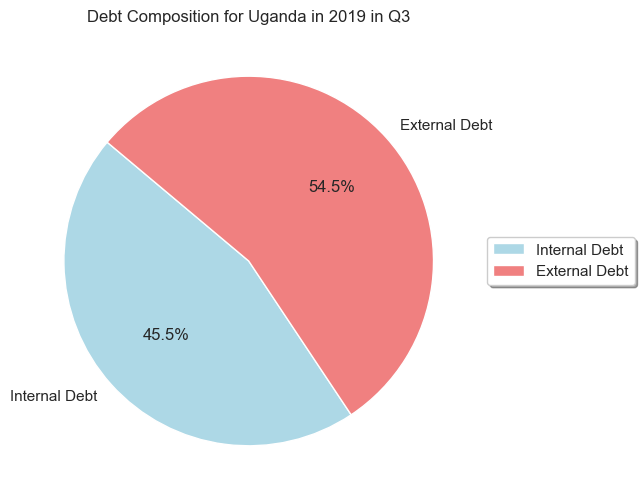

In [87]:
def pie_cart(country, date):
    df = debt_long[(debt_long['Country Name'] == country) & (debt_long['Date'] == date)]
    internal_debt_data  = df[df['Series Code'] == 'DP.DOD.DECD.CR.PS.CD']
    external_debt_data =  df[df['Series Code'] == 'DP.DOD.DECX.CR.PS.CD']

    if internal_debt_data.empty and external_debt_data.empty:
        return print(f'No data available for Internal and External Debt for {country} in {date}.')
    else:
        internal_debt = internal_debt_data['Debt'].iloc[0]
        external_debt = external_debt_data['Debt'].iloc[0]
        labels = ['Internal Debt', 'External Debt']
        debts = [internal_debt, external_debt]
        plt.subplots(figsize=(6, 6))
        plt.pie(debts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightcoral'])
        plt.title(f'Debt Composition for {country} in {date[:4]} in {date[-2:]}')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=1)
        plt.show()
        return

pie_cart('Uganda', '2019Q3')


# 5

Create a function that receives a country and a date, and draws a bar chart with the amounts of the different types of debts of that country on that date

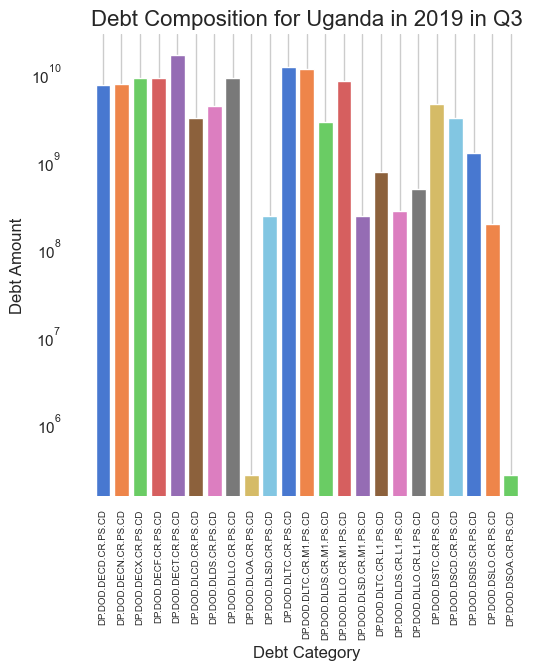

In [88]:
def barchart_all(country, date):
    df = debt_long[(debt_long['Country Name'] == country) & (debt_long['Date'] == date)]
    if df.empty:
        return print(f'No data available for {country} in {date}.')
    else:
        sizes = df['Debt'].tolist()
        labels = df['Series Code'].tolist()
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.bar(labels, sizes, color=sns.color_palette("muted"))
        plt.title(f'Debt Composition for {country} in {date[:4]} in {date[-2:]}', fontsize=16)
        plt.xlabel('Debt Category', fontsize=12)
        plt.ylabel('Debt Amount', fontsize=12)
        plt.yscale('log')
        plt.xticks(rotation=90, ha='center', fontsize=7)
        plt.grid(axis='y', linestyle='', alpha=0.7)
        sns.despine(left=True, bottom=True)
        plt.show()
        return

barchart_all('Uganda', '2019Q3')


# 6

Create a function that receives a list of countries and a type of debt and draws a line chart showing the evolution of that type of debt for those countries (one line per country)

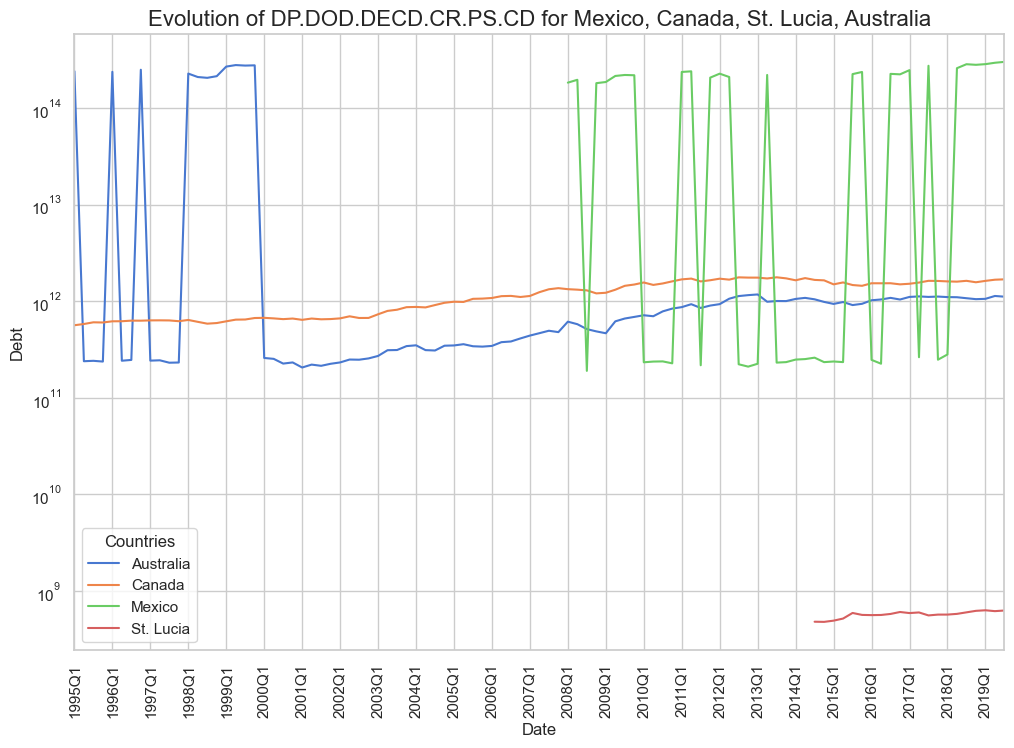

In [89]:
def line_chart_countries(countries, debt_type):

    # Filter data for the selected countries and debt type
    debt_type_df = debt_long[debt_long['Series Code'] == debt_type]
    countries_with_debt = debt_type_df['Country Name'].tolist()

    # Check if one country form the list is in the list of countries with debt
    countries_available = [country for country in countries if country in countries_with_debt]
    if not countries_available:
        countries_str = ", ".join(countries)
        return print(f"No data available for the debt type {debt_type} in {countries_str} ")

    # Check if the selected countries are available for the selected debt type
    countries_not_available = [country for country in countries if country not in countries_with_debt]
    if countries_not_available:
        not_available_str = ', '.join(countries_not_available)
        print(f"The debt type {debt_type} is not available for the following countries: {not_available_str}")

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.title(f'Evolution of {debt_type} for {", ".join(countries)}', fontsize=16)
    country_data = debt_long[(debt_long['Country Name'].isin(countries)) & debt_long['Series Code'].str.contains(debt_type)]
    sns.lineplot(x='Date', y='Debt',hue = 'Country Name', data=country_data, palette='muted')
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Debt')
    plt.yscale('log')
    plt.xlim(country_data['Date'].iloc[0], country_data['Date'].iloc[-1])
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(4))
    plt.legend(title='Countries')

    plt.show()

# Example usage:
countries_to_plot = ['Mexico', 'Canada', 'St. Lucia', 'Australia']
debt_type_to_plot = 'DP.DOD.DECD.CR.PS.CD'  
line_chart_countries(countries_to_plot, debt_type_to_plot)

# 7

Create a function that receives a country and a list of debt types and draws a line chart showing the evolution of those debt types for that country (one line per debt type).

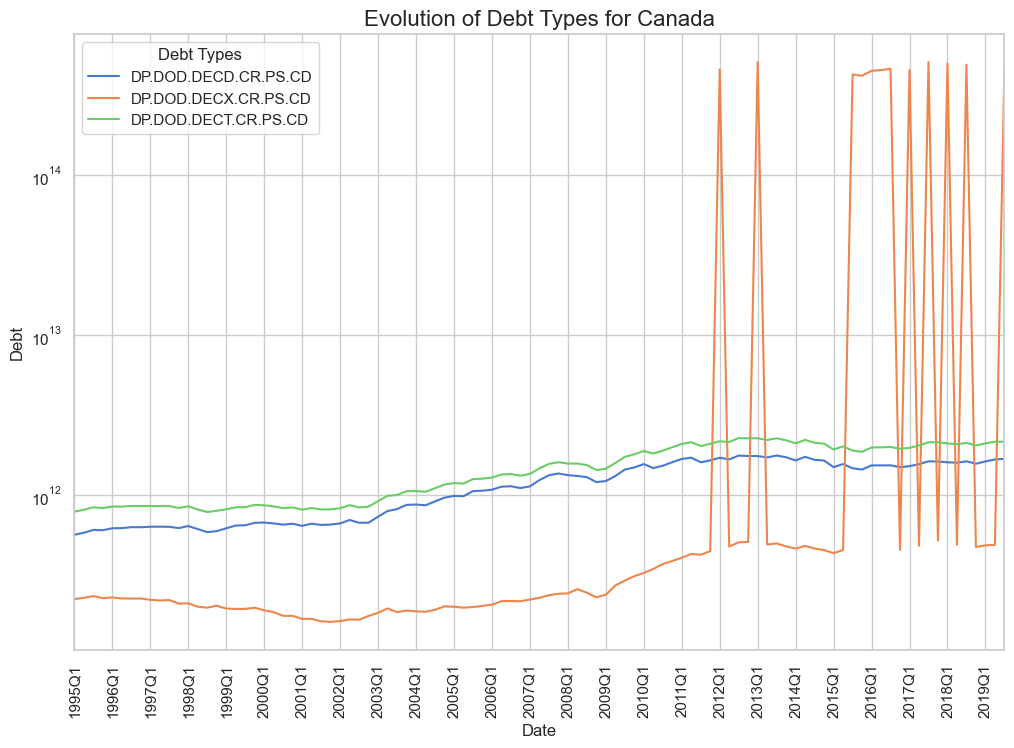

In [90]:
# Exercise 7
def line_chart_debt_types(country, debt_types):

    # Filter data for the selected country and debt types
    country_df = debt_long[debt_long['Country Name'] == country]
    debt_types_available = country_df['Series Code'].tolist()

    # Check if one debt type form the list is in the list of debts types with the given country
    debt_types_available = [debt_type for debt_type in debt_types if debt_type in debt_types_available]
    if not debt_types_available:
        debt_types_str = ", ".join(debt_types)
        return print(f"No data available for {country} and the debt types {debt_types_str}")

    # Check if the selected debt types are available for the selected country
    debt_types_not_available = [debt_type for debt_type in debt_types if debt_type not in debt_types_available]
    if debt_types_not_available:
        not_available_str = ', '.join(debt_types_not_available)
        st.warning(f"{country} does not have the following debt types: {not_available_str}")


    fig, ax = plt.subplots(figsize=(12, 8))
    plt.title(f'Evolution of Debt Types for {country}', fontsize=16)
    country_data = debt_long[(debt_long['Country Name'] == country) & debt_long['Series Code'].isin(debt_types)]
    sns.lineplot(x='Date', y='Debt', hue='Series Code', data=country_data, palette='muted')
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Debt')
    plt.yscale('log')
    plt.xlim(country_data['Date'].iloc[0], country_data['Date'].iloc[-1])
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(4))
    plt.legend(title='Debt Types')
    plt.show()


# Example usage:
debt_types_to_plot = ['DP.DOD.DECD.CR.PS.CD', 'DP.DOD.DECX.CR.PS.CD', 'DP.DOD.DECT.CR.PS.CD']
country_to_plot = 'Canada'
line_chart_debt_types(country_to_plot, debt_types_to_plot)

# 8

Create a function that receives a list of countries and a list of types of debt, and draw a box plot of debt

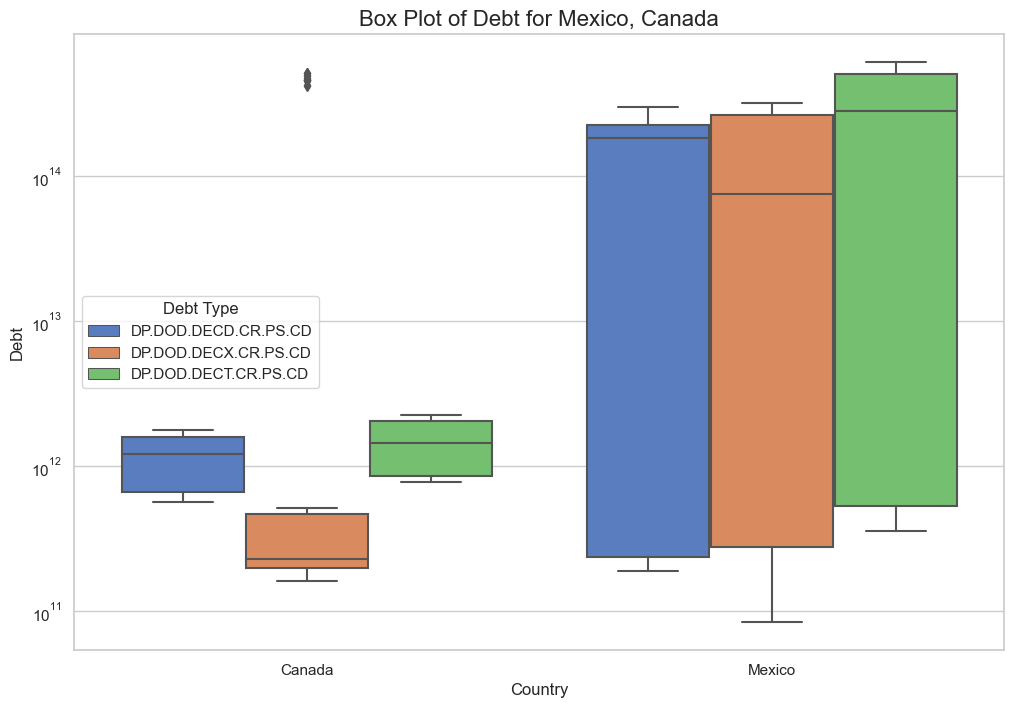

In [95]:
def box_plot_countries(countries, debt_types):
    # Get unique countries and debt types in the entire DataFrame, for the selected other value
    debt_df = debt_long[debt_long['Country Name'].isin(countries)]
    country_df = debt_long[debt_long['Series Code'].isin(debt_types)]
    available_countries = country_df['Country Name'].unique()
    available_debt = debt_long['Series Code'].unique()

    # Check if there are selected countries or debt types that do not have a match in the DataFrame
    missing_countries = [country for country in countries if country not in available_countries]
    missing_debt_types = [debt_type for debt_type in debt_types if debt_type not in available_debt]

    # Check if there is data available for the selected debt types and countries
    filtered_data = debt_long[(debt_long['Country Name'].isin(countries)) & (debt_long['Series Code'].isin(debt_types))]
    if filtered_data.empty:
        countries_str = ', '.join(countries)
        debt_types_str = ', '.join(debt_types)
        return print(f"The combination of {countries_str} and {debt_types_str} does not have any data available.")

    if missing_countries:
        missing_countries_str = ', '.join(missing_countries)
        print(f"The following countries are not in the data: {missing_countries_str}")
    if missing_debt_types:
        missing_debt_types_str = ', '.join(missing_debt_types)
        print(f"The following debt types are not in the data: {missing_debt_types_str}")

    # Create a box plot
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.title(f'Box Plot of Debt for {", ".join(countries)}', fontsize=16)
    sns.boxplot(x='Country Name', y='Debt', hue='Series Code', data=filtered_data, palette='muted')
    plt.xlabel('Country')
    plt.ylabel('Debt')
    plt.yscale('log')
    plt.legend(title='Debt Type')
    plt.show()

# Example usage:
countries_to_plot = ['Mexico', 'Canada']
debt_types_to_plot = ['DP.DOD.DECD.CR.PS.CD', 'DP.DOD.DECX.CR.PS.CD', 'DP.DOD.DECT.CR.PS.CD']
box_plot_countries(countries_to_plot, debt_types_to_plot)


# Exploration of Series Code

In [82]:
list_shortings = debt['Series Code'].unique()
shortings_DE = []
shortings_DL = []
shortings_DS = []

for i in range(len(list_shortings)):
    if list_shortings[i][7:9] == 'DE':
        shortings_DE.append(list_shortings[i])
    if list_shortings[i][7:9] == 'DL':
        shortings_DL.append(list_shortings[i])
    if list_shortings[i][7:9] == 'DS':
        shortings_DS.append(list_shortings[i])

list_shortings

array(['DP.DOD.DECD.CR.PS.CD', 'DP.DOD.DECN.CR.PS.CD',
       'DP.DOD.DECX.CR.PS.CD', 'DP.DOD.DECF.CR.PS.CD',
       'DP.DOD.DECT.CR.PS.CD', 'DP.DOD.DLCD.CR.PS.CD',
       'DP.DOD.DLDS.CR.MV.PS.CD', 'DP.DOD.DLDS.CR.PS.CD',
       'DP.DOD.DLIN.CR.PS.CD', 'DP.DOD.DLLO.CR.PS.CD',
       'DP.DOD.DLOA.CR.PS.CD', 'DP.DOD.DLSD.CR.PS.CD',
       'DP.DOD.DLTC.CR.PS.CD', 'DP.DOD.DLTC.CR.M1.PS.CD',
       'DP.DOD.DLCD.CR.M1.PS.CD', 'DP.DOD.DLDS.CR.M1.PS.CD',
       'DP.DOD.DLIN.CR.M1.PS.CD', 'DP.DOD.DLLO.CR.M1.PS.CD',
       'DP.DOD.DLOA.CR.M1.PS.CD', 'DP.DOD.DLSD.CR.M1.PS.CD',
       'DP.DOD.DLTC.CR.L1.PS.CD', 'DP.DOD.DLCD.CR.L1.PS.CD',
       'DP.DOD.DLDS.CR.L1.PS.CD', 'DP.DOD.DLIN.CR.L1.PS.CD',
       'DP.DOD.DLLO.CR.L1.PS.CD', 'DP.DOD.DLOA.CR.L1.PS.CD',
       'DP.DOD.DSTC.CR.PS.CD', 'DP.DOD.DSCD.CR.PS.CD',
       'DP.DOD.DSDS.CR.PS.CD', 'DP.DOD.DSIN.CR.PS.CD',
       'DP.DOD.DSLO.CR.PS.CD', 'DP.DOD.DSOA.CR.PS.CD'], dtype=object)

**ABBRIVIATIONS 'Series Code'**

---
DP.DOD.DE--.CR.PS.CD: 
- Gross PSD - Total - All maturities - All instruments - XXXXXXXXXX - Nominal Value - US$

DECD = Domestic creditors

DECN = Domestic currency

DECX = External creditors

DECF = Foreign currency

DECT =  'No specification'

---

DP.DOD.DL--.CR.PS.CD:
- Gross PSD - Total - All maturities - XXXXXXX - Nominal Value - US$

DP.DOD.DL--.CR.MV.PS.CD:
- Gross PSD - Total - All maturities - XXXXXXX - Market value - US$ - (Only DLDS)

DP.DOD.DL--.CR.M1.PS.CD:
- Gross PSD - Total - Long-term - With payment due in more than one year - XXXXXXX - Nominal Value - US$

DP.DOD.DL--.CR.L1.PS.CD:
- Gross PSD - Total - Long-term - With payment due in one year or less - XXXXXXX - Nominal Value - US$


**PS,M1:**

DLSD = Special Drawing Rights


**PS,M1,L1:**

DLCD = Currency and deposits

DLIN = Insurance - pensions - and standardized guarantee schemes

DLLO = Loans 

DLOA = Other accounts payable

DLTC = All instruments


**PS,M1,L1,MV:**

DLDS = Debt securities

----
DP.DOD.DS--.CR.PS.CD
- Gross PSD - Total - Short-term - XXXXXXX - Nominal Value - US$

DSTC = All instruments

DSCD = Currency and deposits

DSDS = Debt securities

DSIN = Insurance - pensions - and standardized guarantee schemes

DSLO = Loans 

DSOA = Other accounts payable
